utility functions

In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse as sps
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.tri as tri 
from scipy.sparse.linalg import spsolve

def all_edges(t,p):
    # Find all unique edges in the triangulation t (ne-by-2 array)
    # Second output is indices to the boundary edges.
    edges = np.vstack((t[:,[0,1]], t[:,[1,2]], t[:,[2,0]]))
    key = edges.min(axis=1) + edges.max(axis=1) * p.shape[0]
    _, ix, counts = np.unique(key, return_index=True, return_counts=True)
    return edges[ix, :], np.where(counts == 1)

def boundary_nodes(t,p):
    # Find all boundary nodes in the triangulation t
    edges, boundary_indices = all_edges(t,p)
    return np.unique(edges[boundary_indices, :].flatten())

def boundary_edges(t,p):
    # Find all boundary edges in the triangulation t
    edges, boundary_indices = all_edges(t,p)
    return edges[boundary_indices, :]

def tplot(p, t, u=None):
    # Plot triangular mesh p, t, or contour plot if solution u is provided
    plt.clf()
    plt.axis('equal')
    if u is None:
        plt.tripcolor(p[:,0], p[:,1], t, 0*t[:,0], cmap='Set3',
                      edgecolors='k', linewidth=1)
    else:
        plt.tricontourf(p[:,0], p[:,1], t, u, 20)
        plt.colorbar()
    plt.draw()

def unique_rows(A, return_index=False, return_inverse=False):
    """
    Similar to MATLAB's unique(A, 'rows'), this returns B, I, J
    where B is the unique rows of A and I and J satisfy
    A = B[J,:] and B = A[I,:]
    Returns I if return_index is True
    Returns J if return_inverse is True
    """
    A = np.require(A, requirements='C')
    assert A.ndim == 2, "array must be 2-dim'l"

    orig_dtype = A.dtype
    ncolumns = A.shape[1]
    dtype = np.dtype((np.character, orig_dtype.itemsize*ncolumns))
    B, I, J = np.unique(A.view(dtype),
                        return_index=True,
                        return_inverse=True)

    B = B.view(orig_dtype).reshape((-1, ncolumns), order='C')

    # There must be a better way to do this:
    if (return_index):
        if (return_inverse):
            return B, I, J
        else:
            return B, I
    else:
        if (return_inverse):
            return B, J
        else:
            return B

find triangle's centroid tcenter [Ux,Uy]

In [2]:
def trcent (point,tr):
    pt1 = [(point[tr[0],0]), (point[tr[0],1])]
    pt2 = [(point[tr[1],0]), (point[tr[1],1])]
    pt3 = [(point[tr[2],0]), (point[tr[2],1])]        
    tcenter = [((pt1[0] + pt2[0] + pt3[0])/3), ((pt1[1]+pt2[1]+pt3[1])/3)]
    return tcenter

check if triangles in connection table are inside polygon, eliminate if outside.

In [3]:
from matplotlib.path import Path
import numpy as np

def inboundary(pv,point,DT):
    conn = np.zeros((1,3)).astype(int)
    path = Path(pv)
    
    for i in range (0, len(DT)):
        # take triangles from connection table, call them t
        tr = [(DT[i,0]), (DT[i,1]), (DT[i,2])]
        
        tcenter = trcent(point,tr)
        
        IN = path.contains_point(tcenter)
        
        if(IN == 1):
            conn = np.append(conn, [tr], axis=0)
    conn = np.delete(conn, (0), axis=0)   
    return conn

find maximum area in all triangles in connection table, find the index of max area triangle

In [4]:
def area_max(point,DT):
    ar = [0]
    #ar = np.array((0))
    armax = 0.0
    for i in range (0, len(DT)):               
        pt1 = [(point[DT[i,0],0]), (point[DT[i,0],1])]
        pt2 = [(point[DT[i,1],0]), (point[DT[i,1],1])]
        pt3 = [(point[DT[i,2],0]), (point[DT[i,2],1])]
        
        ar.append(abs(((pt1[0]*(pt2[1]-pt3[1]))+(pt2[0]*(pt3[1]-pt1[1]))+(pt3[0]*(pt1[1]-pt2[1])))/2))
    ar = np.delete(ar, 0, axis=0)
    
    indx = np.argmax(ar)
    armax = ar[indx]
    return armax,indx

find circumcenter c [Ux,Uy] of any trinagle with verticies pt1[Ux,Uy], pt2[Ux,Uy], pt3[Ux,Uy]

In [5]:
def circumfind(pt1,pt2,pt3):
    
    D = 2*(pt1[0]*(pt2[1]-pt3[1])+pt2[0]*(pt3[1]-pt1[1])+pt3[0]*(pt1[1]-pt2[1]))
    Ux = ((pt1[0]**2+pt1[1]**2)*(pt2[1]-pt3[1])+(pt2[0]**2+pt2[1]**2)*(pt3[1]-pt1[1])+(pt3[0]**2+pt3[1]**2)*(pt1[1]-pt2[1]))/D
    Uy = ((pt1[0]**2+pt1[1]**2)*(pt3[0]-pt2[0])+(pt2[0]**2+pt2[1]**2)*(pt1[0]-pt3[0])+(pt3[0]**2+pt3[1]**2)*(pt2[0]-pt1[0]))/D
    c = [(Ux),(Uy)]
    
    return c

find mid points mid1[Ux,Uy], mid2[Ux,Uy], mid3[Ux,Uy] of each side in a trinagle of verticies pt1[Ux,Uy], pt2[Ux,Uy], pt3[Ux,Uy]

In [6]:
def midfind(pt1,pt2,pt3):
    
    mid1 = [(pt1[0] + pt2[0])/2, (pt1[1]+pt2[1])/2]
    mid2 = [(pt2[0] + pt3[0])/2, (pt2[1]+pt3[1])/2]
    mid3 = [(pt3[0] + pt1[0])/2, (pt3[1]+pt1[1])/2]
    return mid1,mid2,mid3

meshing of whole domain. first find circumcenter of largest triangle and add it to list of points. then triangulate and eliminate triangles outside boundaries

In [7]:
def mesh_it(armax,indx,hmax,p,t,pv):
    while (armax > (hmax**2/2)):
        #finding triangle verticies
        pt1 = [(p[t[indx,0],0]), (p[t[indx,0],1])]
        pt2 = [(p[t[indx,1],0]), (p[t[indx,1],1])]
        pt3 = [(p[t[indx,2],0]), (p[t[indx,2],1])]
        #finding triangle circumcenter
        circumcenter = circumfind(pt1,pt2,pt3)
        # add circumcenter to list of points
        p = np.append(p, [circumcenter], axis=0)
        #triangulate again after adding the circumcenter of largest triangle        
        t = tri.Triangulation(p[:,0], p[:,1]).triangles
        t = inboundary(pv,p,t)
        armax,indx = area_max(p,t)
        
    return p,t

refine the mesh. finds the mid points of all triangles, add it to list of points, triangulate and remove outside triangles

In [8]:
def refine_it(p,t,pv):
    p1 = np.zeros((0,2))
    # creating nodes on boundaries
    
    for i in range(0, len(t)):
        tr = [(t[i,0]), (t[i,1]), (t[i,2])]
        #finding triangle verticies
        pt1 = [(p[tr[0],0]), (p[tr[0],1])]
        pt2 = [(p[tr[1],0]), (p[tr[1],1])]
        pt3 = [(p[tr[2],0]), (p[tr[2],1])]
        #find mid points
        mid1,mid2,mid3 = midfind(pt1,pt2,pt3)
           
        # p is the new points table
        p1 = np.append(p1, [mid1], axis=0)
        p1 = np.append(p1, [mid2], axis=0)
        p1 = np.append(p1, [mid3], axis=0)
    # removing doublicate points
    p1 = unique_rows(p1) #instead I will use the below function
    p = np.append(p, p1, axis=0)
    #p = unique_rows(p)
    #p = DataFrame(p).drop_duplicates().values
    #triangulate p to create connection table t
    t = tri.Triangulation(p[:,0], p[:,1]).triangles
    # finding if triangles inside boundary
    t = inboundary(pv,p,t)
    #t = unique_rows(t)
    return p,t

In [9]:
def pmesh(pv,hmax,nref):
    
    x = [0]
    y = [0]
    #circlist = [0]
    # creating nodes on boundaries
    for i in range(0, (len(pv)-1)):
        
        x1 = pv[i,0]
        y1 = pv[i,1]
        x2 = pv[i+1,0]
        y2 = pv[i+1,1]
        l = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        m = np.ceil(l/hmax)
        x0 = np.linspace(x1,x2,m+1)
        y0 = np.linspace(y1,y2,m+1)
        x.extend(x0)
        y.extend(y0)
    point = np.vstack([x,y])
    # p is the new points table [x,y] coordinates
    p = point.T
    # removing doublicate points
    p = unique_rows(p)
    #p = DataFrame(p).drop_duplicates().values
    #triangulate p to create connection table t
    t = tri.Triangulation(p[:,0], p[:,1]).triangles
    # finding if triangles inside boundary
    t = inboundary(pv,p,t)
    # finding area of all triangles and maximum + index relating to maximum
    # here where I discovered unique_rows messed up my p 
    # print(p)
    armax,indx = area_max(p,t)
    # meshing the domain
    p,t = mesh_it(armax,indx,hmax,p,t,pv)
    #refining the domain if href >= 1
    if (nref >= 1):
        for i in range (0, nref):
            p,t = refine_it(p,t,pv)
            armax,indx = area_max(p,t)
            p,t = mesh_it(armax,indx,hmax,p,t,pv)
    e = boundary_nodes(t,p)
    #print(p)
    return p,t,e

In [10]:
def waveguide_edges(p,t):
    xin = [0] 
    yin = [0]
    xout = [0]
    yout = [0]
    xwall = [0]
    ywall = [0]
    e = boundary_edges(t,p)
    e = e[0]
    L = len(e)
    for i in range(0,L):
        if (p[e[i,0],0] == 0.0 and p[e[i,1],0] == 0.0):
            xin.append(e[i,0])
            yin.append(e[i,1])    
        if (p[e[i,0],0] == 5.0 and p[e[i,1],0] == 5.0): 
            xout.append(e[i,0])
            yout.append(e[i,1])     
        if (p[e[i,0],1] == 0.0 and p[e[i,1],1] == 0.0 or p[e[i,0],1] == 1.0 and p[e[i,1],1] == 1.0):
            xwall.append(e[i,0])
            ywall.append(e[i,1])
    ein = np.vstack([xin,yin])
    ein = ein.T
    ein = np.delete(ein, (0), axis=0)
    eout = np.vstack([xout,yout])
    eout = eout.T
    eout = np.delete(eout, (0), axis=0)    
    ewall = np.vstack([xwall,ywall])
    ewall = ewall.T
    ewall = np.delete(ewall, (0), axis=0) 
    return ein, eout, ewall

In [11]:
def femhelmholtz(p,t,ein,eout):
    N = p.shape[0]
    K = sps.lil_matrix((N, N))
    M = sps.lil_matrix((N, N))
    Bin  = sps.lil_matrix((N, N))
    Bout = sps.lil_matrix((N, N))
    bi = np.zeros((N,1))
    Q2 = np.array([[1./12,1./24,1./24],[1./24,1./12,1./24],[1./24,1./24,1./12]])  # 3x3 matrix to calculate M matrix
    Q3 = np.array([[1./3,1./6],[1./6,1./3]])  # 2x2 matrix to calculate Bin and Bout matrices 
    Q4 = np.array([[1./2],[1./2]])  # 2x1 matrix to calculate bi matrix 
    
    for el in t:
        Q = np.hstack((np.ones((3,1)), p[el,:]))
        Area = abs(np.linalg.det(Q)) / 2.0
        c = np.linalg.inv(Q)
        Ah = Area * (np.outer(c[1,:], c[1,:]) + np.outer(c[2,:], c[2,:]))
        K[np.ix_(el,el)] += Ah
        Mh = Area * 2.0 * Q2
        M[np.ix_(el,el)] += Mh    
    for el in ein:
        # d = np.linalg.norm(p[el[0],:]-p[el[1],:], ord=2)
        d = np.sqrt((p[el[0],0]-p[el[1],0])**2+(p[el[0],1]-p[el[1],1])**2)
        Binh = d * Q3
        Bin[np.ix_(el,el)] += Binh
        bih = d * Q4
        bi[np.ix_(el)] += bih
    for el in eout:
        d = np.sqrt((p[el[0],0]-p[el[1],0])**2+(p[el[0],1]-p[el[1],1])**2)
        Bouth = d * Q3
        Bout[np.ix_(el,el)] += Bouth
    
    return K,M,Bin,Bout,bi

## a.

In [12]:
hmax = 0.2
nref = 2
pv = np.array([[0.0,0.0],[5.0,0.0],[5.0,1.0],[3.1,1.0],[3.1,0.2],[2.9,0.2],[2.9,1.0],[2.1,1.0],[2.1,0.2],[1.9,0.2],[1.9,1.0],[0.0,1.0],[0.0,0.0]])
p,t,e = pmesh(pv,hmax,nref)
ein,eout,ewall = waveguide_edges(p,t)
K,M,Bin,Bout,bi = femhelmholtz(p,t,ein,eout)

## b.

In [13]:
k = 6 # starting wave number
k2 = 6.5 # ending wave number
dk = 0.01
m = int((k2-k)/dk)
H = np.zeros((m+1))
kmat = np.zeros((m+1))

#looping over k
for i in range(0, m+1):
    A = K - k**2 * M + 1j* k*(Bin+Bout) 
    b = bi *2*k*1j
    u = spsolve(A.tocsc(), b) 
    H[i] = (np.ndarray.conj(u)).dot(Bout.dot(u))
    kmat[i] = k
    k = k + dk


C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part


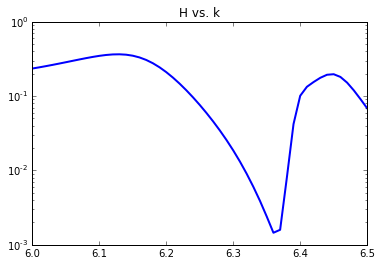

In [14]:
plt.title('H vs. k')
plt.semilogy(kmat,H,lw=2)
plt.show()

## c.

first we find the index in H matrix corresponds to max H, and index of min H

In [15]:
Hmaxi = np.argmax(H) # index for max H
Hmini = np.argmin(H) # index for min H

In [16]:
print(Hmaxi,Hmini)

13 36


find the corresponding k for min H and max H. call it kmin and kmax 

In [17]:
kmax = kmat[Hmaxi]
kmin = kmat[Hmini]

In [18]:
print(kmax,kmin)

6.13 6.36


In [19]:
A = K - kmax**2 * M + 1j* kmax*(Bin+Bout) 
b = bi *2*kmax*1j
umax = spsolve(A.tocsc(), b)

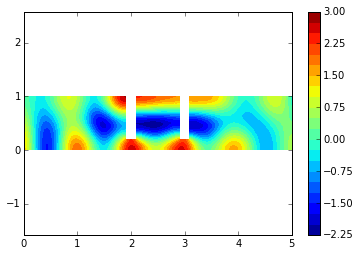

In [20]:
tplot(p,t,umax.real)

In [21]:
A = K - kmin**2 * M + 1j* kmin*(Bin+Bout) 
b = bi *2*kmin*1j
umin = spsolve(A.tocsc(), b)

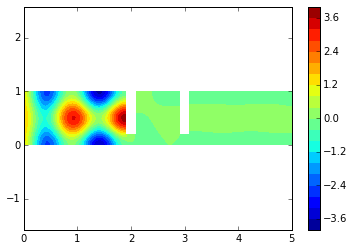

In [22]:
tplot(p,t,umin.real)